In [ ]:
# link: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568



# Algorithms that are designed for binary classification can be adapted for use for multi-class problems.
# This involves using a strategy of fitting multiple binary classification models for each class vs. all other classes (called one-vs-rest) or one model for each pair of classes (called one-vs-one).
# https://machinelearningmastery.com/types-of-classification-in-machine-learning/

In [ ]:

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
# from nltk.corpus import stopwords
import nltk

import re
from bs4 import BeautifulSoup
%matplotlib inline



In [ ]:
from google.colab import files
uploaded = files.upload()

# Dataset is now stored in a Pandas Dataframe

Saving Bert_Model_Data_Agri.csv to Bert_Model_Data_Agri.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Bert_Model_Data_Agri.csv']),encoding='latin-1')

In [ ]:
df = df[['Item','Exiobase Spend Category']]
df.head()

,Item,Exiobase Spend Category
0,Beef,Products of meat cattle
1,"Abondance cheese, from cow's milk",Dairy products
2,"Apricot, canned in light syrup, drained",Food products nec
3,"Apricot, canned in light syrup, not drained",Food products nec
4,"Apricot, in syrup, canned, drained",Food products nec


In [ ]:
df.describe()

,Item,Exiobase Spend Category
count,17852,17851
unique,3988,29
top,Fruits,"Vegetables, fruit, nuts"
freq,211,10962


In [ ]:
# Drop all rows with NaN values
df = df.dropna().reset_index(drop=True)

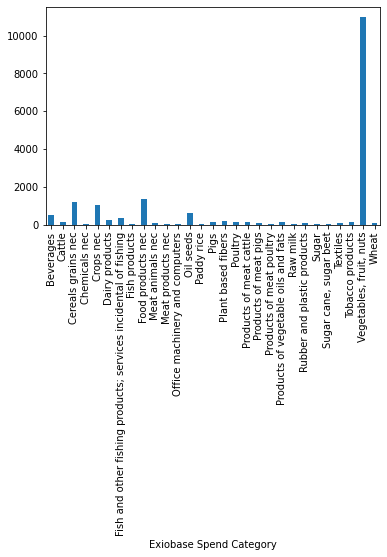

In [ ]:
df.groupby(['Exiobase Spend Category']).size().plot.bar() #Highly Unbalanced

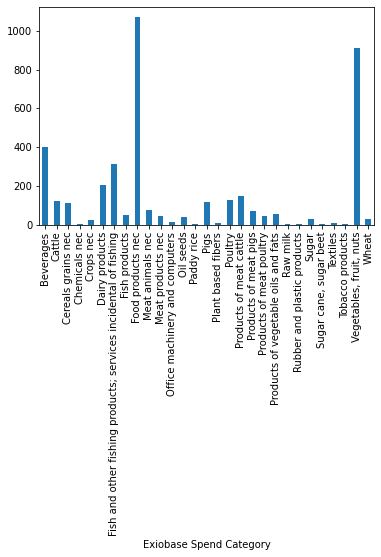

In [ ]:
df.drop_duplicates(inplace=True)
df.groupby(['Exiobase Spend Category']).size().plot.bar() #Still highly Unbalanced after dropping duplicate rows

In [ ]:
#Clean dataset first
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text
    
df['Item'] = df['Item'].apply(clean_text)
df.iloc[621] #previously is 'Pumpkin (cucurbita moschata), pulp, raw'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Item                       pumpkin cucurbita moschata pulp raw
Exiobase Spend Category                Vegetables, fruit, nuts
Name: 621, dtype: object

In [ ]:
df['Exiobase Spend Category'].value_counts()

Food products nec                                                  1069
Vegetables, fruit, nuts                                             910
Beverages                                                           400
Fish and other fishing products; services incidental of fishing     311
Dairy products                                                      205
Products of meat cattle                                             148
Poultry                                                             129
Cattle                                                              123
Pigs                                                                114
Cereals grains nec                                                  109
Meat animals nec                                                     77
Products of meat pigs                                                72
Products of vegetable oils and fats                                  54
Fish products                                                   

**USING SMOTE TO SOLVE IMBALANCED CLASSIFICATION (RE SAMPLING):**

In [ ]:
#using smote requires removing outliers -> removing those classes with only one 1 sample
# df['Exiobase Spend Category'].value_counts() == 1

# value_count_lst = df['Exiobase Spend Category'].value_counts()[:]
# value_count_lst
for idx,name in enumerate(df['Exiobase Spend Category'].value_counts().index.tolist()):
  if df['Exiobase Spend Category'].value_counts()[idx] <=1:
    df = df[df['Exiobase Spend Category'] != name]

In [ ]:
#Create Train test split first
X = df['Item']
y = df['Exiobase Spend Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
X_train

1430                              millet cooked unsalted
17565                                           lime raw
2467     yogurt fermented milk dairy specialty w cereals
1715                  baby food jar vegetables 46 months
226                                    beef round cooked
                              ...                       
1131                               flageolet bean cooked
1295                 mixed vegetables ratatouille frozen
861                              swordfish roasted baked
16132                         textured vegetable protein
7294                                          flax fibre
Name: Item, Length: 2811, dtype: object

In [ ]:
# recreate training dataframe by combining X_train and y_train
df_train = pd.DataFrame(X_train) 
df_train['Exiobase Spend Category'] = y_train
df_train

,Item,Exiobase Spend Category
1430,millet cooked unsalted,Wheat
17565,lime raw,"Vegetables, fruit, nuts"
2467,yogurt fermented milk dairy specialty w cereals,Dairy products
1715,baby food jar vegetables 46 months,Food products nec
226,beef round cooked,Products of meat cattle
...,...,...
1131,flageolet bean cooked,Food products nec
1295,mixed vegetables ratatouille frozen,"Vegetables, fruit, nuts"
861,swordfish roasted baked,Fish and other fishing products; services inci...
16132,textured vegetable protein,Food products nec


In [ ]:
df_train['Exiobase Spend Category'].value_counts()

Food products nec                                                  767
Vegetables, fruit, nuts                                            630
Beverages                                                          279
Fish and other fishing products; services incidental of fishing    216
Dairy products                                                     146
Products of meat cattle                                            100
Cattle                                                              86
Poultry                                                             82
Pigs                                                                81
Cereals grains nec                                                  76
Products of meat pigs                                               53
Meat animals nec                                                    52
Fish products                                                       35
Products of vegetable oils and fats                                 34
Produc

In [ ]:
# https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5
# https://arxiv.org/abs/1106.1813
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import imblearn
print(imblearn.__version__)

0.8.1


In [ ]:
df_train.head()

,Item,Exiobase Spend Category
1430,millet cooked unsalted,Wheat
17565,lime raw,"Vegetables, fruit, nuts"
2467,yogurt fermented milk dairy specialty w cereals,Dairy products
1715,baby food jar vegetables 46 months,Food products nec
226,beef round cooked,Products of meat cattle


Original class counts: Counter({'Food products nec': 767, 'Vegetables, fruit, nuts': 630, 'Beverages': 279, 'Fish and other fishing products; services incidental of fishing': 216, 'Dairy products': 146, 'Products of meat cattle': 100, 'Cattle': 86, 'Poultry': 82, 'Pigs': 81, 'Cereals grains nec': 76, 'Products of meat pigs': 53, 'Meat animals nec': 52, 'Fish products': 35, 'Products of vegetable oils and fats': 34, 'Meat products nec': 29, 'Products of meat poultry': 29, 'Oil seeds': 27, 'Wheat': 20, 'Sugar': 20, 'Crops nec': 16, 'Office machinery and computers': 8, 'Plant based fibers': 7, 'Textiles': 5, 'Chemicals nec': 3, 'Rubber and plastic products': 3, 'Raw milk': 3, 'Sugar cane, sugar beet': 2, 'Paddy rice': 2})
Class counts after resampling Counter({'Wheat': 767, 'Vegetables, fruit, nuts': 767, 'Dairy products': 767, 'Food products nec': 767, 'Products of meat cattle': 767, 'Fish and other fishing products; services incidental of fishing': 767, 'Beverages': 767, 'Products of me

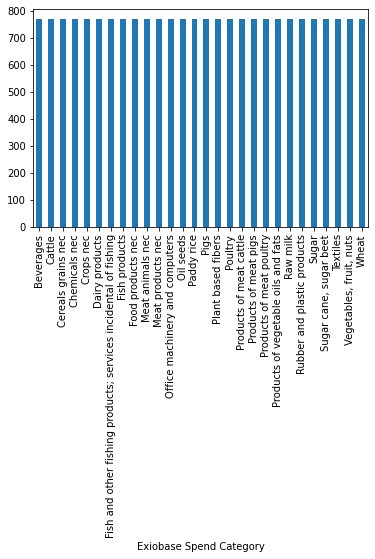

In [ ]:
from imblearn.over_sampling import SMOTEN

from collections import Counter
print(f"Original class counts: {Counter(df_train['Exiobase Spend Category'])}")

#Oversampling the data
smoten = SMOTEN(random_state = 101, k_neighbors=1)
X, y = smoten.fit_resample(np.array(df_train[['Item']]), df_train['Exiobase Spend Category'].values)
print(f"Class counts after resampling {Counter(y)}")
print(X)

df_train_oversampler = pd.DataFrame(X, columns = ['Item'])
df_train_oversampler['Exiobase Spend Category'] = y
df_train_oversampler
df_train_oversampler.groupby(['Exiobase Spend Category']).size().plot.bar()

In [ ]:
df_train_oversampler['Item'].apply(lambda x: len(x.split(' '))).sum() #71016 words to work with

71016

In [ ]:
# Convert back to X_train and y_train from df_train_oversampler dataframe
X_train = df_train_oversampler['Item']
y_train = df_train_oversampler['Exiobase Spend Category']

In [ ]:
# labels = {'Paddy rice':0,
#           'Wheat':1,
#           'Cereals grains nec':2,
#           'Vegetables, fruit, nuts':3,
#           'Oil seeds':4,
#           'Sugar cane, sugar beet': 5,
#           'Plant based fibers': 6,
#           'Crops nec': 7,
#           'Cattle' :8,
#           'Pigs': 9,
#           'Poultry': 10,
#           'Meat animals nec':11,
#           'Raw milk':12,
#           'Wool, silk-worm cocoons':13,
#           'Manure - conventional':14,
#           'Manure - biogas':15,
#           'Fish and other fishing products; services incidental of fishing':16,
#           'Anthracite':17,
#           'Coking Coal':18,
#           'Other Bituminous Coal':19,
#           'Sub-Bituminous Coal':20,
#           'Patent Fuel':21,
#           'Lignite/Brown Coal':22,
#           'BKB/Peat Briquettes':23,
#           'Peat':24,
#           'Chemical and fertilizer minerals, salt and other mining and quarrying products n.e.c.':25,
#           'Crude petroleum and services related to crude oil extraction, excluding surveying':26,
#           'Natural gas and services related to natural gas extraction, excluding surveying':27,
#           'Natural Gas Liquids':28,
#           'Other Hydrocarbons':29,
#           'Uranium and thorium ores':30,	
#           'Iron ores':31,
#           'Copper ores and concentrates':32,
#           'Nickel ores and concentrates':33,
#           'Aluminium ores and concentrates':34,	
#           'Precious metal ores and concentrates':35,
#           'Lead, zinc and tin ores and concentrates':36,	
#           'Other non-ferrous metal ores and concentrates':37,	
#           'Stone':38,
#           'Sand and clay':39,	
#           'Products of meat cattle':40,	
#           'Products of meat pigs':41,
#           'Products of meat poultry':42,	
#           'Meat products nec':43,
#           'Products of vegetable oils and fats':44,	
#           'Dairy products':	45,
#           'Processed rice':	46,
#           'Sugar':47,
#           'Food products nec':48,	
#           'Beverages':49,
#           'Fish products':50,	
#           'Tobacco products':51,	
#           'Food waste for treatment: biogasification and land application':52,	
#           'Food waste for treatment: composting and land application	Food waste for treatment: incineration':53,	
#           'Food waste for treatment: landfill':54,
#           'Textiles':55,
#           'Textiles waste for treatment: incineration':56,
#           'Textiles waste for treatment: landfill':57,
#           'Wearing apparel; furs':58,
#           'Leather and leather products':59,
#           'Wood and products of wood and cork (except furniture); articles of straw and plaiting materials':60,
#           'Wood material for treatment, reprocessing of secondary wood material into new wood material':61,
#           'Wood waste for treatment: incineration':62,
#           'Wood waste for treatment: landfill':63,
#           'Pulp':64,
#           'Paper and paper products':65,
#           'Printed matter and recorded media':66,
#           'Secondary paper for treatment, re-processing of secondary paper to new paper':67,
#           'Coke Oven Coke':68,
#           'Gas Coke':69,
#           'Coal Tar':70,
#           'Charcoal':71,
#           'Motor Gasoline':72,
#           'Aviation Gasoline':73,
#           'Gasoline Type Jet Fuel':74,
#           'Kerosene Type Jet Fuel':75,
#           'Kerosene':76,
#           'Gas/Diesel Oil':77,
#           'Heavy Fuel Oil':78,
#           'Refinery Gas':79,
#           'Liquefied Petroleum':80,
#           'Refinery Feedstocks':81,
#           'Ethane':82,
#           'Naphtha':83,
#           'White Spirit & SBP':84,
#           'Lubricants':85,
#           'Bitumen':86,
#           'Paraffin Waxes':87,
#           'Petroleum Coke':88,
#           'Non-specified Petrol':89,
#           'Nuclear fuel':90,
#           'N-fertiliser':91,
#           'P- and other fertiliser':92,
#           'Chemicals nec':93,
#           'Plastics, basic':94,
#           'Plastic waste for treatment: incineration':95,
#           'Plastic waste for treatment: landfill':96,
#           'Rubber and plastic products':97,
#           'Glass and glass products':98,
#           'Secondary glass for treatment, re-processing of secondary glass into new glass':99,
#           'Ceramic goods':100,
#           'Bricks, tiles and construction products, in baked clay':101,
#           'Cement, lime and plaster':102,
#           'Ash for treatment, re-processing of ash into clinker':103,
#           'Other non-metallic mineral products':104,
#           'Basic iron and steel and of ferro-alloys and first products thereof':105,
#           'Secondary steel for treatment, re-processing of secondary steel into new steel':106,
#           'Precious metals':107,
#           'Secondary precious metals for treatment, re-processing of secondary precious metals into new precious metals':108,
#           'Aluminium and aluminium products':109,
#           'Secondary aluminium for treatment, re-processing of secondary aluminium into new aluminium':110,
#           'Lead, zinc and tin and products thereof':111,
#           'Secondary lead for treatment, reprocessing of secondary lead into new lead':112,
#           'Copper products':113,
#           'Secondary copper for treatment, reprocessing of secondary copper into new copper':114,
#           'Other non-ferrous metal products':115,
#           'Secondary other non-ferrous metals for treatment, reprocessing of secondary other non-ferrous metals into new other non-ferrous metals':116,
#           'Foundry work services':117,
#           'Fabricated metal products, except machinery and equipment':118,
#           'Machinery and equipment n.e.c.':119,
#           'Office machinery and computers':120,
#           'Electrical machinery and apparatus n.e.c.':121,
#           'Radio, television and communication equipment and apparatus n.e.c.':122,
#           'Medical, precision and optical instruments, watches and clocks':123,
#           'Motor vehicles, trailers and semi-trailers':124,
#           'Other transport equipment':125,
#           'Furniture; other manufactured goods n.e.c.':126,
#           'Secondary raw materials':127,
#           'Construction work':128,
#           'Secondary construction material for treatment, re-processing of secondary construction material into new construction material':129,
#           'Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessories':130,
#           'Wholesale trade and commission trade services, except for motor vehicles and motorcycles':131,
#           'Retail trade services, except of motor vehicles and motor cycles':132,
#           'Retail trade services of motor fuel':133,
#           'Hotel and restaurant services':134,
#           'Railway transportation services':135,
#           'Other land transportation services':136,
#           'Transportation services via pipeline':137,
#           'Sea and coastal water transportation services':138,
#           'Air transport services':139,
#           'Supporting and auxiliary transport services, travel agency services':140,
#           'Post and telecommunications services':141,
#           'Financial intermediation services, except insurance and pension funding services':142,
#           'Insurance and pension funding services, except compulsory social security services':143,
#           'Supporting and auxil':144
#           }

In [ ]:
# labels = labels.keys()
# labels = list(labels)
# labels = list(df_train['Exiobase Spend Category'].unique())
# labels = list(df['Exiobase Spend Category'].unique())
labels = set(y_train)
len(labels)

28

### **USING LINEAR SUPPORT VECTOR MACHINE:** unbalanced accuracy: 0.74378, balanced accuracy using SMOTE:

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

# %%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,))


accuracy 0.648424543946932
                                                                 precision    recall  f1-score   support

                                                      Beverages       0.89      0.79      0.84       121
                                                         Cattle       0.75      0.41      0.53        37
                                             Cereals grains nec       0.73      0.33      0.46        33
                                                  Chemicals nec       0.00      0.00      0.00         0
                                                      Crops nec       0.18      0.30      0.22        10
                                                 Dairy products       0.58      0.25      0.35        59
Fish and other fishing products; services incidental of fishing       0.77      0.64      0.70        95
                                                  Fish products       0.33      0.14      0.20        14
                           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
X_test
r = [1, 2]
ser = pd.Series(r, copy=False)
ser.iloc[0] = 'apple'
ser.iloc[1] = 'computer'
ser

0       apple
1    computer
dtype: object

In [ ]:
sgd.predict(ser)

array(['Vegetables, fruit, nuts', 'Food products nec'], dtype='<U63')

### **USING LOGISTIC REGRESSION** unbalanced accuracy: 0.74461, balanced accuracy using SMOTE:0.96325

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

# %%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 %s' % f1_score(y_pred, y_test, average='micro'))
print(classification_report(y_test, y_pred)) #target_names=labels

accuracy 0.7371475953565506
f1 0.7371475953565506
                                                                 precision    recall  f1-score   support

                                                      Beverages       0.94      0.88      0.91       121
                                                         Cattle       0.55      0.59      0.57        37
                                             Cereals grains nec       0.73      0.58      0.64        33
                                                      Crops nec       0.29      0.20      0.24        10
                                                 Dairy products       0.59      0.69      0.64        59
Fish and other fishing products; services incidental of fishing       0.82      0.80      0.81        95
                                                  Fish products       0.48      0.71      0.57        14
                                              Food products nec       0.78      0.78      0.78       302
    

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in

In [ ]:
r = [1, 2]
ser = pd.Series(r, copy=False)
ser.iloc[0] = 'apple'
ser.iloc[1] = 'laptop'
ser
logreg.predict(ser)
# logreg.predict_proba(ser)

array(['Vegetables, fruit, nuts', 'Office machinery and computers'],
      dtype=object)

In [ ]:
labels

{'Beverages',
 'Cattle',
 'Cereals grains nec',
 'Chemicals nec',
 'Crops nec',
 'Dairy products',
 'Fish and other fishing products; services incidental of fishing',
 'Fish products',
 'Food products nec',
 'Meat animals nec',
 'Meat products nec',
 'Office machinery and computers',
 'Oil seeds',
 'Paddy rice',
 'Pigs',
 'Plant based fibers',
 'Poultry',
 'Products of meat cattle',
 'Products of meat pigs',
 'Products of meat poultry',
 'Products of vegetable oils and fats',
 'Raw milk',
 'Rubber and plastic products',
 'Sugar',
 'Sugar cane, sugar beet',
 'Textiles',
 'Vegetables, fruit, nuts',
 'Wheat'}

### **USING BOW with Keras (neural network)** 

In [ ]:
# https://github.com/tensorflow/workshops/blob/master/extras/keras-bag-of-words/keras-bow-model.ipynb

In [ ]:
import itertools
import os
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [ ]:
# train_size = int(len(df_oversampler) * .7)
train_items = X_train   
train_labels = y_train

test_items = X_test
test_labels = y_test

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_items) # only fit on train

In [ ]:
x_train = tokenize.texts_to_matrix(train_items)
x_test = tokenize.texts_to_matrix(test_items)

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_labels)

y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels) #maybe can try to balance the dataset first



In [ ]:
from keras.utils import np_utils
num_classes = np.max(y_train) + 1
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [ ]:
batch_size = 32
epochs =5

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
604/604 [==============================] - 10s 13ms/step - loss: 0.5538 - accuracy: 0.9028 - val_loss: 4.0598 - val_accuracy: 0.0638
Epoch 2/5
604/604 [==============================] - 7s 11ms/step - loss: 0.1595 - accuracy: 0.9506 - val_loss: 3.0534 - val_accuracy: 0.0638
Epoch 3/5
604/604 [==============================] - 7s 12ms/step - loss: 0.1189 - accuracy: 0.9607 - val_loss: 2.2943 - val_accuracy: 0.0638
Epoch 4/5
604/604 [==============================] - 7s 12ms/step - loss: 0.0987 - accuracy: 0.9662 - val_loss: 1.7132 - val_accuracy: 0.3966
Epoch 5/5
604/604 [==============================] - 7s 11ms/step - loss: 0.0880 - accuracy: 0.9689 - val_loss: 1.3498 - val_accuracy: 0.7514


In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])
print(score)


38/38 [==============================] - 0s 6ms/step - loss: 0.8519 - accuracy: 0.7521
Test accuracy: 0.7520729899406433
[0.8518936634063721, 0.7520729899406433]


In [ ]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_items.iloc[i][:50], "...")
    print('Actual label:' + test_labels.iloc[i][:50])
    print("Predicted label: " + predicted_label + "\n")  


gouda cheese cows milk ...
Actual label:Cattle
Predicted label: Products of meat cattle

ham pastry crusty ...
Actual label:Pigs
Predicted label: Food products nec

chicken average ...
Actual label:Poultry
Predicted label: Products of meat poultry

vegetables 34 types mashed ...
Actual label:Vegetables, fruit, nuts
Predicted label: Food products nec

cabbage red raw ...
Actual label:Vegetables, fruit, nuts
Predicted label: Vegetables, fruit, nuts

chaource cheese cows milk ...
Actual label:Products of meat cattle
Predicted label: Products of meat cattle

coconut kernel dried ...
Actual label:Vegetables, fruit, nuts
Predicted label: Vegetables, fruit, nuts

cider ...
Actual label:Beverages
Predicted label: Beverages

haddock grilled panfried ...
Actual label:Fish and other fishing products; services incident
Predicted label: Fish and other fishing products; services incidental of fishing

macadamia nut grilled salted ...
Actual label:Vegetables, fruit, nuts
Predicted label: Vegetables, 

In [ ]:
from keras.utils.generic_utils import serialize_keras_object

items = ['apple','chicken']

ser = pd.Series(items)
ser_tokenize = tokenize.texts_to_matrix(ser)


for i in range(len(ser)):
    prediction = model.predict(np.array([ser_tokenize[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print("Item: " + ser[i]) 
    print("Predicted label: " + predicted_label + "\n")  

Item: apple
Predicted label: Vegetables, fruit, nuts

Item: chicken
Predicted label: Products of meat poultry



In [ ]:
from keras.models import save_model, load_model

# Save the model
filepath = 'C:/Users/user/OneDrive/Documents/GitHub/unravel_items_classification/MLModel/text.pt'
save_model(model, filepath)



INFO:tensorflow:Assets written to: C:/Users/user/OneDrive/Documents/GitHub/unravel_items_classification/MLModel/text.pt/assets


In [ ]:
test = load_model('/content/kerasModel', compile = True)

test


In [ ]:
for i in range(len(ser)):
    prediction = test.predict(np.array([ser_tokenize[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print("Item: " + ser[i]) 
    print("Predicted label: " + predicted_label + "\n")  

Item: apple
Predicted label: Vegetables, fruit, nuts

Item: chicken
Predicted label: Products of meat poultry



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **NAIVE BAYES**


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

naiveB = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('multinomialnb', MultinomialNB(alpha=1)), #alpha in multinomialNB represents the additive smoothing parameter. If it is 0, then there will be no smoothing.
                                                           #Smoothing solves the zero probability problem in Naive Bayes algorithm, which is the problem of assigning probability equal to zero for every new data point in the test set.
               ])

naiveB.fit(X_train, y_train)

y_pred = naiveB.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 %s' % f1_score(y_pred, y_test, average='micro'))
print(classification_report(y_test, y_pred)) #target_names=labels

accuracy 0.6650082918739635
f1 0.6650082918739635
                                                                 precision    recall  f1-score   support

                                                      Beverages       0.69      0.83      0.75       121
                                                         Cattle       0.61      0.54      0.57        37
                                             Cereals grains nec       0.88      0.21      0.34        33
                                                  Chemicals nec       0.00      0.00      0.00         0
                                                      Crops nec       0.23      0.30      0.26        10
                                                 Dairy products       0.69      0.31      0.42        59
Fish and other fishing products; services incidental of fishing       0.75      0.80      0.77        95
                                                  Fish products       1.00      0.07      0.13        14
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

### **RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

RandomFC = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 101)),
               ])

RandomFC.fit(X_train, y_train)

y_pred = RandomFC.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 %s' % f1_score(y_pred, y_test, average='micro'))
print(classification_report(y_test, y_pred)) #target_names=labels

accuracy 0.703150912106136
f1 0.703150912106136
                                                                 precision    recall  f1-score   support

                                                      Beverages       0.94      0.86      0.90       121
                                                         Cattle       0.63      0.51      0.57        37
                                             Cereals grains nec       0.69      0.33      0.45        33
                                                  Chemicals nec       0.00      0.00      0.00         0
                                                      Crops nec       0.25      0.20      0.22        10
                                                 Dairy products       0.70      0.66      0.68        59
Fish and other fishing products; services incidental of fishing       0.77      0.51      0.61        95
                                                  Fish products       0.33      0.36      0.34        14
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

### **Word2vec AND LOGISTIC REGRESSION**

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test
# all_data

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 22682/22682 [00:00<00:00, 1909195.33it/s]


In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy 0.62106135986733
                                                                 precision    recall  f1-score   support

                                                      Beverages       0.81      0.84      0.83       121
                                                         Cattle       0.57      0.46      0.51        37
                                             Cereals grains nec       0.33      0.24      0.28        33
                                                  Chemicals nec       0.00      0.00      0.00         0
                                                      Crops nec       0.40      0.40      0.40        10
                                                 Dairy products       0.67      0.47      0.55        59
Fish and other fishing products; services incidental of fishing       0.61      0.57      0.59        95
                                                  Fish products       0.36      0.36      0.36        14
                            

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in